In [216]:
import sys
import numpy as np
import xarray as xr
import scipy.stats as spy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pickle 

In [217]:
sys.path.append("../")
import Online_DA_utils as oda

In [218]:
import importlib
importlib.reload(oda)

<module 'Online_DA_utils' from '../Online_DA_utils.py'>

In [219]:
t=0

# limname = 'cesm_lme_nh'
# modname = 'cesm_lme'
# obsname = 'cesm_lme'

#limname = 'cesm_lme_Amon'
limname = 'multimod_MPI_GFDL_HadGEM3_CanESM_Amon'
modname = 'cesm_lme_Amon'
obsname = 'cesm_lme_Amon'
#obsname = 'cmip6_mpi_hist_regridlme'

## Load L: 

In [220]:
LIM = oda.load_L(limname)
LIMd = LIM['LIMd']
LIMd.keys()

Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/multimod/LIMcast_multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon_ntrain29_202110_cesm_lme_Amon_validy_1851_1950_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20220114.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

In [221]:
ndof_total = 0
limvars = ['tas','psl','zg','tos','sit','sic']
for var in limvars: 
    ndof_total = ndof_total+LIMd['var_dict'][var]['var_ndof']

## Load Pb: 

In [222]:
priordir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/priors/'
priorname = 'Xb_initial_'+modname+'_300ndof_1651_1850.pkl'
validname = 'Xb_initial_'+modname+'_300ndof_1851_2005.pkl'

Xb_initial_data = pickle.load(open(priordir+priorname,"rb"))
Xb_initial_allt = Xb_initial_data['Xb_initial']

In [223]:
Xb_valid_data = pickle.load(open(priordir+validname,"rb"))
Xb_valid_allt = Xb_valid_data['Xb_initial']

In [224]:
Pb_initial = LIMd['C_0']

## Load observations: 

In [225]:
obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
obsfilename = 'TAS_pseudo_obs_'+obsname+'_1851_2005.pkl'

pseudo_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

In [226]:
pseudo_obs_full = pseudo_obs_data['observations']
obs_lat = pseudo_obs_data['obs_lat']
obs_lon = pseudo_obs_data['obs_lon']
obs_mask = pseudo_obs_data['H']

In [227]:
pseudo_obs_2d = np.reshape(pseudo_obs_full, (pseudo_obs_full.shape[0]*pseudo_obs_full.shape[1],
                           pseudo_obs_full.shape[2]))

In [228]:
tas_3d = pseudo_obs_data['X_var_3d'] 
tas_2d = np.reshape(tas_3d,(tas_3d.shape[0]*tas_3d.shape[1],tas_3d.shape[2]))

In [229]:
tas_2d.shape, Xb_valid_allt.shape

((6912, 1860), (300, 1860))

## Load H: 

In [230]:
obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
obsfilename = 'TAS_pseudo_obs_'+obsname+'_1851_2005.pkl'

pseudo_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

In [231]:
pseudo_obs_full = pseudo_obs_data['observations']
obs_lat = pseudo_obs_data['obs_lat']
obs_lon = pseudo_obs_data['obs_lon']
obs_mask = pseudo_obs_data['H']

In [232]:
H_cap, nobs, ndof = oda.build_H_time(obs_mask[:,:,0])

In [233]:
H = np.zeros((nobs,ndof_total))
H[:,0:6912] = H_cap

In [234]:
neofs = 300

In [235]:
E3_all = np.zeros((ndof_total,neofs))
ntrunc = 50

for v,var in enumerate(limvars): 
    E3_all[LIMd['var_dict'][var]['var_inds'],int(v*ntrunc):int((v+1)*ntrunc)] = LIMd['E3'][var]/np.sqrt(LIMd['standard_factor'][var])

In [236]:
LIMd['standard_factor']['tas'], np.sqrt(LIMd['standard_factor']['tas'])

(22750.1904006552, 150.83166246068893)

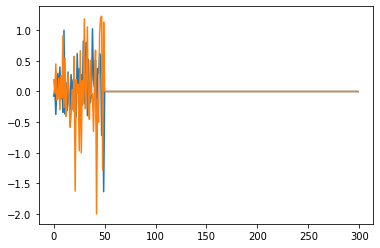

In [237]:
i =0
plt.plot(E3_all[i,:])
plt.plot(H_eof[i,:])

In [238]:
U = E3_all

H_eof = np.matmul(H,U)

In [239]:
H_eof.shape, H.shape, U.shape, H.shape

((324, 300), (324, 35424), (35424, 300), (324, 35424))

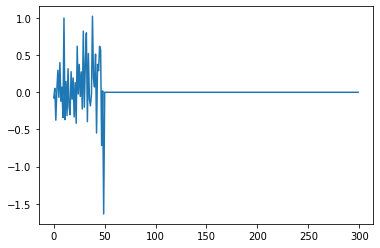

In [240]:
plt.plot(H_eof[0,:])

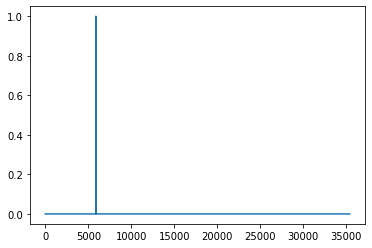

In [241]:
plt.plot(H[320,:])

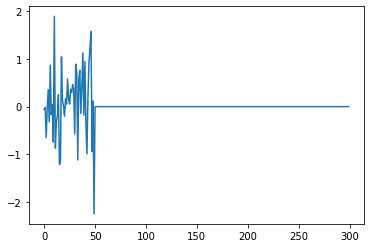

In [242]:
plt.plot(U[10,:])

## Calculate R: 

In [243]:
Hx = np.matmul(H_eof,Xb_valid_allt)

In [244]:
H_eof.shape,Xb_valid_allt.shape

((324, 300), (300, 1860))

In [245]:
Hx_cap = np.matmul(H_cap,tas_2d)

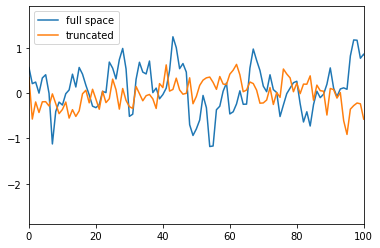

In [246]:
plt.plot(Hx_cap[0,:], label='full space')
plt.plot(Hx[0,:], label='truncated')
plt.xlim(0,100)

plt.legend()

In [247]:
epsilon = Hx_cap - Hx

In [248]:
R = np.matmul(epsilon,epsilon.T)/(epsilon.shape[0]-1)

### Update Pb: 

In [249]:
def calculate_K(Pb,H,R):
    K_num = np.matmul(Pb,H.T)
    K_den = np.matmul(np.matmul(H,Pb),H.T)+R
    K_den_inv = np.linalg.inv(K_den)
    K = np.matmul(K_num,K_den_inv)
    
    return K 

In [250]:
neof = 300

In [251]:
part = np.identity(neof) - np.matmul(K,H_eof)
Pa = np.matmul(part,Pb_initial)

### Forecast step: 

In [252]:
lag = 1
Gt = np.real(np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam_L_adj']*lag))),LIMd['veci']))

N = oda.calc_error_covariance(LIMd)

In [253]:
Pa_trace = np.zeros((100))
Cov_predict_trace = np.zeros((100))
lag=1
N = oda.calc_error_covariance(LIMd)

for t in range(100):
    K = calculate_K(Pb_initial, H_eof, R)
    part = np.identity(neof) - np.matmul(K,H_eof)
    Pa = np.matmul(part,Pb_initial)
    Pa_trace[t] = np.trace(Pa)
    
#    Gt = np.real(np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam_L_adj']*lag))),LIMd['veci']))
    Cov_predict = oda.calc_lim_covariance(Pa, LIMd, N)
    Cov_predict_trace[t] = np.trace(Cov_predict)
    
    Pb_inital = Cov_predict.copy()

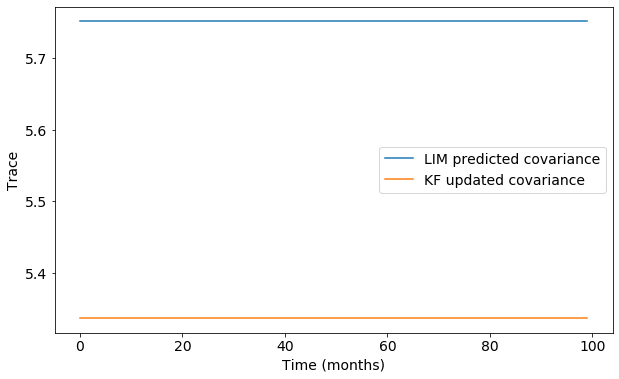

In [254]:
fig = plt.figure(figsize=(10,6))

plt.plot(Cov_predict_trace, label='LIM predicted covariance')
plt.plot(Pa_trace, label='KF updated covariance')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Trace', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

Text(0.5, 1.0, 'Posterior Covariance')

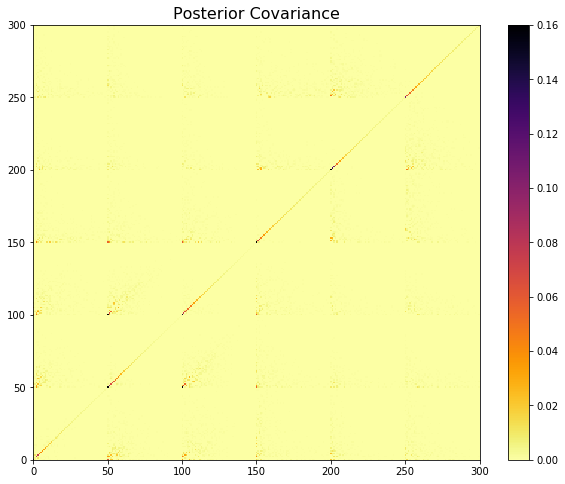

In [255]:
fig = plt.figure(figsize=(10,8))
plt.pcolormesh(Pa, cmap = 'inferno_r', vmin=0, vmax=0.16)
plt.colorbar()
plt.title('Posterior Covariance', fontsize=16)

Text(0.5, 1.0, 'Forecasted Covariance \n(absolute value)')

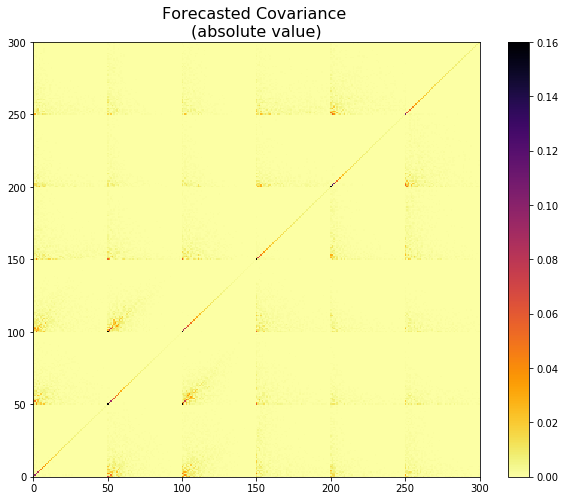

In [256]:
fig = plt.figure(figsize=(10,8))
plt.pcolormesh(np.abs(Cov_predict),cmap = 'inferno_r', vmin=0, vmax=0.16)
plt.colorbar()
plt.title('Forecasted Covariance \n(absolute value)', fontsize=16)